In [1]:
import os
import cv2
import glob
import PIL
import openslide
import numpy as np
import pandas as pd
import mahotas.polygon 
import matplotlib.pyplot as plt

from tqdm import tqdm
from lxml import etree
from copy import deepcopy

WSI_flist = glob.glob("./data/camelyon/Tumor_WSI/*.tif")
roi_flist = glob.glob("./data/camelyon/Tumor_WSI/*_tissue_mask.png")
annotation_flist = glob.glob("./data/camelyon/Tumor_annotations/*.xml")

print(f"WSI: {len(WSI_flist)}\troi: {len(roi_flist)}\tannotation: {len(annotation_flist)}")

WSI: 111	roi: 111	annotation: 111


In [9]:
test_number = 0

slide_image = openslide.OpenSlide(WSI_flist[test_number])

for i in range(slide_image.level_count):
    print(f"Dimensions of level {i}: {slide_image.level_dimensions[i]}")

level_0_shape = slide_image.level_dimensions[0]
level_1_shape = slide_image.level_dimensions[1]
level_3_shape = slide_image.level_dimensions[3]
level_5_shape = slide_image.level_dimensions[5]

Dimensions of level 0: (97792, 221184)
Dimensions of level 1: (49152, 110592)
Dimensions of level 2: (24576, 55296)
Dimensions of level 3: (12288, 27648)
Dimensions of level 4: (6144, 13824)
Dimensions of level 5: (3072, 7168)
Dimensions of level 6: (1536, 3584)
Dimensions of level 7: (1024, 2048)
Dimensions of level 8: (512, 1024)
Dimensions of level 9: (512, 512)


In [5]:
from bs4 import BeautifulSoup as bs

xml = bs(open(annotation_flist[test_number]), 'xml')
print(xml.prettify())

<?xml version="1.0" encoding="utf-8"?>
<ASAP_Annotations>
 <Annotations>
  <Annotation Color="#F4FA58" Name="_0" PartOfGroup="_0" Type="Polygon">
   <Coordinates>
    <Coordinate Order="0" X="71924.4" Y="131761"/>
    <Coordinate Order="1" X="71918.7" Y="131761"/>
    <Coordinate Order="2" X="71918.7" Y="131767"/>
    <Coordinate Order="3" X="71901.6" Y="131801"/>
    <Coordinate Order="4" X="71901.6" Y="131807"/>
    <Coordinate Order="5" X="71890.3" Y="131812"/>
    <Coordinate Order="6" X="71890.3" Y="131818"/>
    <Coordinate Order="7" X="71890.3" Y="131824"/>
    <Coordinate Order="8" X="71884.6" Y="131829"/>
    <Coordinate Order="9" X="71884.6" Y="131835"/>
    <Coordinate Order="10" X="71867.5" Y="131858"/>
    <Coordinate Order="11" X="71867.5" Y="131863"/>
    <Coordinate Order="12" X="71856.1" Y="131881"/>
    <Coordinate Order="13" X="71850.4" Y="131881"/>
    <Coordinate Order="14" X="71839" Y="131898"/>
    <Coordinate Order="15" X="71833.3" Y="131909"/>
    <Coordinate O

In [11]:
roi_image_path = roi_flist[test_number]

roi_image = cv2.imread(roi_image_path, cv2.IMREAD_GRAYSCALE)
roi_image = cv2.transpose(cv2.resize(roi_image, level_3_shape))
roi_image.shape

(12288, 27648)

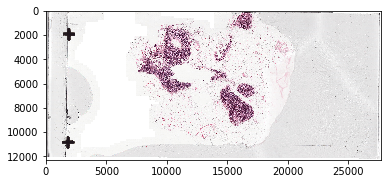

In [12]:
level_3_image = cv2.transpose(np.array(slide_image.read_region((0, 0), 3, level_3_shape).convert("RGB")))
plt.imshow(level_3_image)
plt.show()

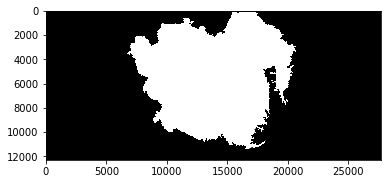

In [13]:
plt.imshow(roi_image, cmap='gray')
plt.show()

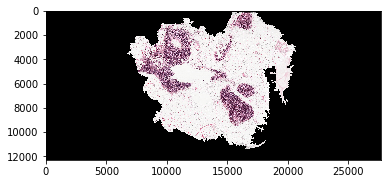

In [14]:


roi_applied_image = deepcopy(level_3_image)
roi_applied_image[roi_image == 0, :] = 0
plt.imshow(roi_applied_image)
plt.show()

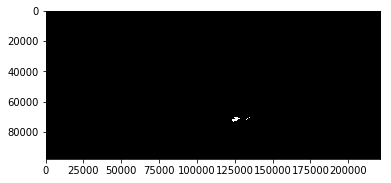

In [17]:
mask_value = 255
mask_array = np.zeros(level_0_shape, dtype=np.uint8)

mask_xml_tree = etree.parse(annotation_flist[test_number])
ASAP_Annotations_tree = mask_xml_tree.getroot()
Annotations_tree = ASAP_Annotations_tree[0]

for Annotation_tree in Annotations_tree:
    Annotaion_Type = Annotation_tree.attrib['Type']
    Annotation_PartOfGroup = Annotation_tree.attrib['PartOfGroup']
    Coordinates_tree = Annotation_tree[0]

    if(Annotaion_Type == "Polygon"):
        polygon_points = []

        for Coordinate in Coordinates_tree.iter("Coordinate"):
            x = float(Coordinate.attrib["X"])
            y = float(Coordinate.attrib["Y"])
            polygon_points.append((round(x), round(y)))

        mahotas.polygon.fill_polygon(polygon_points, mask_array, mask_value)
        
plt.imshow(mask_array, cmap='gray')
plt.show()

  0%|          | 0/111 [00:00<?, ?it/s]

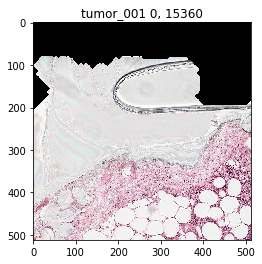

RuntimeError: No active exception to reraise

In [20]:
patch_size = 512
w, h = patch_size, patch_size
level_of_interest = level_0_shape
roi_ratio_threshold = 0.7

for patient in tqdm(range(len(WSI_flist))):
    patient_id = WSI_flist[patient].split("/")[-1].split('.')[0]
    
    for x_index, x in enumerate(range(0, level_of_interest[0], patch_size)):
        for y_index, y in enumerate(range(0, level_of_interest[1], patch_size)):

            patch_image = roi_applied_image[x:x+w, y:y+h]
            patch_label = mask_array[x:x+w, y:y+h]
            roi_ratio = np.sum(np.mean(patch_image, axis=-1) != 0) / (patch_size * patch_size)

            if roi_ratio >= roi_ratio_threshold:
#                 plt.imshow(patch_image)
#                 plt.title(f"{patient_id} {x}, {y}")
#                 plt.show()
                
#                 raise
                
                if np.sum(patch_label != 0) > 0:
                    cv2.imwrite(f"./data/camelyon/patch_image/{patient_id}_{x}-{y}_window-{patch_size}_positive_image.jpg", patch_image)
                    cv2.imwrite(f"./data/camelyon/patch_image/{patient_id}_{x}-{y}_window-{patch_size}_positive_label.jpg", patch_label)
                else:
                    cv2.imwrite(f"./data/camelyon/patch_image/{patient_id}_{x}-{y}_window-{patch_size}_negative_image.jpg", patch_image)
                    cv2.imwrite(f"./data/camelyon/patch_image/{patient_id}_{x}-{y}_window-{patch_size}_negatvie_label.jpg", patch_label)

                
        